In [16]:
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from matplotlib import pyplot as plt
from functools import partial
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Lambda
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import cv2
import os
import keras

In [17]:
df_X = pd.read_csv('dataset/train_features.csv')
df_y = pd.read_csv('dataset/train_target.csv')

In [18]:
df_X

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.00,0.0,0.00,0.00
1,0,0.000004,0.00,0.0,0.00,0.00
2,0,0.000008,0.00,0.0,0.00,0.00
3,0,0.000012,0.00,0.0,0.00,0.00
4,0,0.000016,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...
1049995,2799,0.001480,-89256.32,-164614.6,48186.29,-147910.20
1049996,2799,0.001484,-29233.44,-179404.2,109534.40,-111591.10
1049997,2799,0.001488,37147.25,-190011.7,178781.10,-86836.78
1049998,2799,0.001492,98278.50,-190771.4,245726.70,-75660.00


In [19]:
df_y

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4
...,...,...,...,...,...
2795,2795,200.0,200.0,50.0,1.0
2796,2796,-400.0,-400.0,150.0,0.2
2797,2797,-100.0,0.0,50.0,0.2
2798,2798,100.0,100.0,125.0,0.6


In [20]:
for col in df_X.columns:
    print(f'{col}: {df_X[col].isnull().values.any()}')
for col in df_y.columns:
    print(f'{col}: {df_y[col].isnull().values.any()}')

id: False
Time: False
S1: False
S2: False
S3: False
S4: False
id: False
X: False
Y: False
M: False
V: False


In [21]:
def data_processing(data_frame,feature_list,conc_list=list()):
    for feature in feature_list:
        conc_list.append(np.asarray(data_frame[feature]).reshape(-1,375,1))
    conc_array = np.concatenate(conc_list,axis=2)
    array = conc_array.transpose(0,2,1)
    return array

(2800, 4, 375)


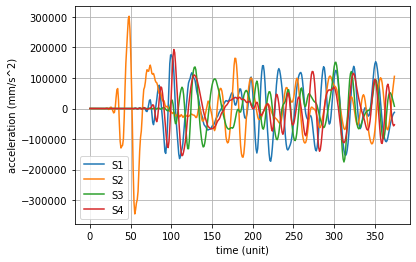

In [22]:
data = data_processing(df_X,['S1','S2','S3','S4'])

plt.figure(figsize=(6,4))
plt.plot(data[777].T)
plt.legend(['S1','S2','S3','S4'])
plt.grid(True)
plt.xlabel('time (unit)')
plt.ylabel('acceleration (mm/s^2)')

x = data
print(x.shape)

In [23]:
data.shape

(2800, 4, 375)

In [24]:
def generate_agg_feats(data_set : pd.DataFrame) -> pd.DataFrame:
    
    max_feats = data_set.groupby(['id']).max().add_suffix('_max').iloc[:,1:]
    min_feats = data_set.groupby(['id']).min().add_suffix('_min').iloc[:,1:]
    mean_feats = data_set.groupby(['id']).mean().add_suffix('_mean').iloc[:,1:]
    std_feats = data_set.groupby(['id']).std().add_suffix('_std').iloc[:,1:]
    median_feats = data_set.groupby(['id']).median().add_suffix('_median').iloc[:,1:]
    skew_feats = data_set.groupby(['id']).skew().add_suffix('_skew').iloc[:,1:]
    
    agg_data = pd.concat([max_feats,min_feats,
                          mean_feats,std_feats,median_feats,skew_feats],
                        axis=1)
    
    return agg_data

In [25]:
df_X = generate_agg_feats(df_X)

In [26]:
df_X

,S1_max,S2_max,S3_max,S4_max,S1_min,S2_min,S3_min,S4_min,S1_mean,S2_mean,...,S3_std,S4_std,S1_median,S2_median,S3_median,S4_median,S1_skew,S2_skew,S3_skew,S4_skew
id,,,,,,,,,,,,,,,,,,,,,
0,235080.9,235080.90,231773.4,286557.2,-315471.5,-315471.50,-168789.1,-293865.7,-308.304553,-308.304553,...,73381.881823,93657.794500,-17.249630,-17.249630,0.000000e+00,0.008652,-0.000219,-0.000219,0.299376,-0.212332
1,1069688.0,1244737.00,951349.6,1095499.0,-826482.9,-2390317.00,-1137225.0,-1306526.0,12780.176893,981.778780,...,393470.633500,468914.485995,0.000000,-1090.979000,1.053139e-06,0.000000,0.521826,-0.701078,-0.088361,0.018837
2,383092.2,150770.40,148724.0,168649.2,-364591.8,-161006.00,-150458.2,-201313.7,-674.289628,-1575.681938,...,53274.867908,64025.270683,-8063.518000,0.000000,0.000000e+00,0.000000,0.516960,-0.087335,0.160090,-0.100796
3,379650.3,378475.30,394448.7,487880.4,-329680.7,-726961.00,-333712.8,-463918.9,2164.216981,-11274.728589,...,144260.409981,143137.423122,0.000118,-10742.910000,5.255491e-07,21.546210,-0.055517,-0.475508,-0.089726,0.113817
4,754833.0,321731.20,373526.8,397334.0,-592148.9,-378091.60,-423593.5,-472361.4,-980.480585,-6966.912566,...,150043.470527,131857.519354,-19297.320000,0.000000,1.173251e-05,1384.087000,0.826098,-0.107505,-0.157477,-0.216489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,698079.1,1027622.00,1031316.0,1037711.0,-793812.4,-720545.40,-1155664.0,-1703724.0,5600.614397,5885.824925,...,312439.374562,359013.359936,0.000797,0.000000,0.000000e+00,-31130.460000,-0.042545,0.247155,0.001388,-0.583126
2796,290787.9,144759.00,119504.7,157180.4,-493104.6,-179902.70,-100318.6,-180438.7,-1215.328099,2702.879683,...,43118.928262,59443.406732,1667.086000,0.001836,0.000000e+00,0.000000,-1.639586,-0.353089,0.311429,-0.357093
2797,109273.7,98441.96,109713.6,162800.1,-127440.0,-90686.41,-101889.3,-123130.7,436.239993,276.327514,...,38062.358026,40343.480882,0.211343,0.000105,0.000000e+00,-0.000364,-0.017294,0.075720,0.135764,0.301025


In [27]:
x_list = df_X.to_numpy().tolist()

In [28]:
y = df_y.drop(['id','X','Y','V'],axis=1)
y_numpy = y.to_numpy()
y_list = y_numpy.tolist()

In [29]:
train_test_index = int(len(x_list)*0.8)
zip_list = list(zip(x_list,y_list))
random.shuffle(zip_list)
x_array,y_array = zip(*zip_list)
x_train,y_train = np.array(x_array[0:train_test_index]),np.array(y_array[0:train_test_index])
x_test,y_test = np.array(x_array[train_test_index:]),np.array(y_array[train_test_index:])

In [30]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)
x_train_scaled

array([[-1.13399679, -1.11202173, -1.15375365, ..., -0.28742115,
        -0.36626328, -0.27652352],
       [ 0.65745733,  1.57183975,  0.31444901, ...,  0.61507741,
         0.34083098,  0.18259318],
       [ 1.83682138,  1.27899421,  1.2070002 , ...,  1.12519227,
        -0.47506848,  0.03509369],
       ...,
       [ 0.84308556,  2.67789177,  1.32409439, ...,  0.42331687,
        -0.72884819, -0.27976377],
       [-0.29506621,  0.33048564,  0.12927597, ...,  0.589277  ,
        -0.0869826 ,  0.89596297],
       [-0.45268399, -0.49256501, -0.0624119 , ..., -0.04574452,
        -0.76957205,  2.20045791]])

In [31]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = minmax_scaler.fit_transform(y_train)
y_test_scaled = minmax_scaler.fit_transform(y_test)
y_train_scaled = np.ravel(y_train_scaled)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

In [33]:
pipelines = []
pipelines.append(('LR', Pipeline([('LR',LinearRegression())])))
pipelines.append(('LASSO', Pipeline([('LASSO', Lasso())])))
pipelines.append(('ENet', Pipeline([('EN', ElasticNet())])))
pipelines.append(('KNN', Pipeline([('KNN', KNeighborsRegressor())])))
pipelines.append(('CART', Pipeline([('CART', DecisionTreeRegressor())])))
pipelines.append(('GBM', Pipeline([('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, x_train_scaled, y_train_scaled, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(-cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, np.array(results).mean(), np.array(results).std())
    print(msg)
    results = []

LR: 0.203928 (0.007880)
LASSO: 0.288826 (0.012791)
ENet: 0.288826 (0.012791)
KNN: 0.177321 (0.010047)
CART: 0.151414 (0.015169)
GBM: 0.163655 (0.006014)


In [42]:
from sklearn.model_selection import GridSearchCV

#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,75,100,150,200,300,400]), 
                  learning_rate = np.array([0.01,0.05,0.1,0.2,0.3,0.5]),
                  max_features = np.array([3,4,5,6,7]))
model = GradientBoostingRegressor()
kfold = KFold(n_splits=5)
grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(x_train_scaled, y_train_scaled)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.269412 (0.007260) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 50}
-0.261738 (0.007393) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 75}
-0.255909 (0.006793) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 100}
-0.247059 (0.006860) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 150}
-0.239943 (0.006070) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 200}
-0.228086 (0.005588) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 300}
-0.218622 (0.005127) with: {'learning_rate': 0.01, 'max_features': 3, 'n_estimators': 400}
-0.268550 (0.007390) with: {'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 50}
-0.260822 (0.007057) with: {'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 75}
-0.254867 (0.006960) with: {'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 100}
-0.245774 (0.006305) with: {'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 150}
-0.

In [60]:
from sklearn.metrics import mean_absolute_error as mae
gb_reg = GradientBoostingRegressor(learning_rate = 0.3, max_features = 7, n_estimators = 400)
gb_reg.fit(x_train_scaled, y_train_scaled)
y_pred = gb_reg.predict(x_test_scaled)
MAE = mae(y_test_scaled, y_pred)

In [61]:
MAE

0.15631554587392596

In [62]:
from sklearn.model_selection import GridSearchCV

#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
param_grid={"splitter":["best","random"],
            "max_depth" : [1,9,12],
           "min_samples_leaf":[1,3,5,7,9],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
#param_grid = dict(n_estimators=np.array([50,75,100,150,200,300,400]),max_features = np.array([3,4,5,6,7]))
model = DecisionTreeRegressor()
kfold = KFold(n_splits=5)
grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(x_train_scaled, y_train_scaled)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.269839 (0.008131) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.276464 (0.006506) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.269839 (0.008131) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.275733 (0.006345) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.271479 (0.006245) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.3, 'splitter': 'best'}
-0.278663 (0.006833) with: {'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.3, 'splitte

-0.266539 (0.005963) with: {'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.266667 (0.006880) with: {'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.3, 'splitter': 'best'}
-0.279096 (0.007232) with: {'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.3, 'splitter': 'random'}
-0.270360 (0.006347) with: {'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.4, 'splitter': 'best'}
-0.285265 (0.006723) with: {'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.4, 'splitter': 'random'}
-0.278096 (0.004232) with: {'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.5, 'splitter': 'best'

-0.278096 (0.004232) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.5, 'splitter': 'best'}
-0.289124 (0.008116) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.5, 'splitter': 'random'}
-0.248155 (0.010136) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
-0.266368 (0.006467) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
-0.260169 (0.006106) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.2, 'splitter': 'best'}
-0.270720 (0.002954) with: {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.2, 'splitter': 'random'}
-0.266667 

In [93]:
model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [65]:
from sklearn.metrics import mean_absolute_error as mae
gb_reg = DecisionTreeRegressor(max_depth=9,max_features='auto',max_leaf_nodes=None,min_samples_leaf=1,
                              min_weight_fraction_leaf=0.1,splitter='best')
gb_reg.fit(x_train_scaled, y_train_scaled)
y_pred = gb_reg.predict(x_test_scaled)
MAE = mae(y_test_scaled, y_pred)

In [66]:
MAE

0.24939871582676645